In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interactive, VBox, HBox
from IPython.display import display

# =============================================================================
# PHẦN 1: CÁC HÀM GIẢ LẬP CỐT LÕI (v7.0 - DẤU ẤN 360 ĐỘ)
# =============================================================================

def tao_dom_gaussian(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    """Vẽ một "đốm sáng" Gaussian 2D (hình elip) lên ma trận."""
    if cuong_do <= 0: return ma_tran # Bỏ qua nếu cường độ không đáng kể
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    
    # Tính toán cho hiệu ứng "quấn quanh" (wrap-around) trên trục X
    dx1 = xs - x
    dx2 = xs - (x + k_thuoc_x) # Dịch sang phải 1 chu kỳ
    dx3 = xs - (x - k_thuoc_x) # Dịch sang trái 1 chu kỳ
    # Chọn khoảng cách ngắn nhất
    dx = np.minimum(np.abs(dx1), np.minimum(np.abs(dx2), np.abs(dx3)))

    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y**2) ) + ( dx**2 / (do_rong_x**2) )
    
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

def gia_lap_ban_do_tinh_v7(goc_MCP, goc_PIP, goc_DIP, k_thuoc=8):
    """
    Giả lập bản đồ TĨNH 8x8 - PHIÊN BẢN VẬT LÝ v7.1 (ĐÃ TỐI ƯU)
    Logic "DẤU ẤN 360 ĐỘ" - Sửa lỗi "Liên kết Gân"
    """
    ban_do = np.zeros((k_thuoc, k_thuoc))
    
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP_chu_dong = np.deg2rad(goc_DIP) # Đây là góc "chủ động" (đáp án thật)

    # --- QUY LUẬT "LIÊN KẾT GÂN" (ĐÃ TỐI ƯU) ---
    
    # 1. Tính "Hệ số Khóa" (Stiffness Factor), từ 0.0 đến 1.0
    stiffness_factor = 0.0
    if goc_MCP > 70: stiffness_factor += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness_factor += (goc_PIP - 60) / 30.0
    stiffness_factor = np.clip(stiffness_factor, 0, 1.0) # Giới hạn max là 1.0

    # 2. Tính "ảnh hưởng" (influence)
    # Tối ưu: Ngay cả khi "khóa" 100%, góc chủ động vẫn chiếm 30% ảnh hưởng
    # và góc thụ động chiếm 70% ảnh hưởng.
    # Điều này đảm bảo góc DIP thật (chu_dong) không bao giờ bị xóa bỏ.
    influence_passive = stiffness_factor * 0.7  # Tối đa 70% ảnh hưởng từ góc thụ động
    influence_active = 1.0 - influence_passive  # Tối thiểu 30% ảnh hưởng từ góc chủ động
    
    # 3. Tính góc DIP "thụ động" (bị kéo theo PIP)
    rad_DIP_thu_dong = rad_PIP * 0.5  # Ví dụ: DIP luôn bị kéo gập bằng 50% của PIP
    
    # 4. Trộn (Blend) hai góc
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * influence_active) + (rad_DIP_thu_dong * influence_passive)

    # --- KẾT THÚC QUY LUẬT MỚI ---
    
    
    # --- 1. ĐỊNH NGHĨA TỌA ĐỘ CÁC ĐIỂM TRÊN BẢN ĐỒ TRẢI PHẲNG ---
    # Tọa độ Y (Dọc ngón tay)
    y_MCP_joint = 7.0
    y_Pad1 = 6.0
    y_PIP_joint = 5.0
    y_Pad2 = 4.0
    y_DIP_joint = 3.0
    y_Pad3 = 2.0
    y_Tip = 1.0
    
    # Tọa độ X (Chu vi ngón tay)
    x_back = 0.0  # Mu bàn tay
    x_front = 4.0 # Lòng bàn tay (phía các đệm thịt)

    # --- 2. TÍNH CƯỜNG ĐỘ DỰA TRÊN GÓC (VẬT LÝ CHÍNH) ---
    # (Sử dụng rad_DIP_hieu_luc để tính cường độ)
    cuong_do_MCP_joint = 1.0 * np.sin(rad_MCP)
    cuong_do_PIP_joint = 1.0 * np.sin(rad_PIP)
    cuong_do_DIP_joint = 1.0 * np.sin(rad_DIP_hieu_luc)
    
    cuong_do_Pad1 = 0.2 + 0.8 * np.sin(rad_MCP)
    cuong_do_Pad2 = 0.2 + 0.8 * np.sin(rad_PIP)
    cuong_do_Pad3 = 0.2 + 0.8 * np.sin(rad_DIP_hieu_luc)
    cuong_do_Tip  = 0.3 + 0.7 * np.sin((rad_MCP + rad_PIP + rad_DIP_hieu_luc) / 3)

    # --- 3. VẼ CÁC "VÀNH ĐAI" ÁP SUẤT ---
    # (Sử dụng rad_DIP_hieu_luc để vẽ)
    tao_dom_gaussian(ban_do, (y_MCP_joint, x_back), cuong_do_MCP_joint, do_rong_y=0.8, do_rong_x=2.0)
    tao_dom_gaussian(ban_do, (y_PIP_joint, x_back), cuong_do_PIP_joint, do_rong_y=0.8, do_rong_x=2.0)
    tao_dom_gaussian(ban_do, (y_DIP_joint, x_back), cuong_do_DIP_joint, do_rong_y=0.8, do_rong_x=2.0)
    
    tao_dom_gaussian(ban_do, (y_Pad1, x_front), cuong_do_Pad1, do_rong_y=1.0, do_rong_x=2.5)
    tao_dom_gaussian(ban_do, (y_Pad2, x_front), cuong_do_Pad2, do_rong_y=1.0, do_rong_x=2.5)
    tao_dom_gaussian(ban_do, (y_Pad3, x_front), cuong_do_Pad3, do_rong_y=1.0, do_rong_x=2.5)
    tao_dom_gaussian(ban_do, (y_Tip, x_front), cuong_do_Tip, do_rong_y=0.8, do_rong_x=2.0)
    
    # --- 4. THÊM NHIỄU VÀ CHUẨN HÓA ---
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.1
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
        
    return ban_do

# --- HÀM gia_lap_ban_do_dong (Không cần thay đổi) ---
# --- HÀM MỚI: tao_dom_gaussian_khong_wrap ---
def tao_dom_gaussian_khong_wrap(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    """Vẽ một "đốm sáng" Gaussian 2D (hình elip) lên ma trận mà KHÔNG có hiệu ứng quấn quanh."""
    if cuong_do <= 0: return ma_tran 
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    
    # KHÔNG tính toán dx2, dx3. Khoảng cách chỉ là trực tiếp
    dx = xs - x 

    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y**2) ) + ( dx**2 / (do_rong_x**2) )
    
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

# --- Cập nhật hàm gia_lap_ban_do_dong để sử dụng hàm mới này ---
def gia_lap_ban_do_dong(vi_tri_tham_do, do_cung, k_thuoc=8):
    """Giả lập bản đồ ĐỘNG khi gantry thăm dò từ trên xuống."""
    ban_do = np.zeros((k_thuoc, k_thuoc))
    cuong_do = do_cung / 10.0
    
    # Điều chỉnh do_rong cho đốm phản lực sắc nét hơn
    do_rong_y_dong = 0.8 - (do_cung / 10.0) * 0.4
    do_rong_x_dong = 0.8 - (do_cung / 10.0) * 0.4 # Đốm sáng sắc nét hơn

    # SỬ DỤNG HÀM MỚI KHÔNG CÓ WRAP-AROUND TẠI ĐÂY
    tao_dom_gaussian_khong_wrap(ban_do, vi_tri_tham_do, cuong_do, do_rong_y_dong, do_rong_x_dong)

    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.05
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
    return ban_do

# --- HÀM ve_khung_xuong_3d (Không cần thay đổi) ---
def ve_khung_xuong_3d(ax, goc_MCP, goc_PIP, goc_DIP, mau='b', label=''):
    L1, L2, L3 = 3, 2, 1
    rad_MCP = np.deg2rad(goc_MCP); rad_PIP = np.deg2rad(goc_PIP); rad_DIP = np.deg2rad(goc_DIP)
    J0 = [0, 0, 0]
    J1 = [0, L1 * np.cos(rad_MCP), L1 * np.sin(rad_MCP)]
    goc_tich_luy_PIP = rad_MCP + rad_PIP
    J2 = [0, J1[1] + L2 * np.cos(goc_tich_luy_PIP), J1[2] + L2 * np.sin(goc_tich_luy_PIP)]
    goc_tich_luy_DIP = goc_tich_luy_PIP + rad_DIP
    Tip = [0, J2[1] + L3 * np.cos(goc_tich_luy_DIP), J2[2] + L3 * np.sin(goc_tich_luy_DIP)]
    points = np.array([J0, J1, J2, Tip])
    ax.plot(points[:, 0], points[:, 1], points[:, 2], marker='o', color=mau, label=label)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title("Mô hình 3D"); ax.set_xlim([-1, 1]); ax.set_ylim([0, 6]); ax.set_zlim([0, 6])

# =============================================================================
# PHẦN 2: TẠO GIAO DIỆN TƯƠNG TÁC
# =============================================================================

def cap_nhat_giao_dien(goc_MCP, goc_PIP, goc_DIP, do_cung):
    fig, (ax1, ax2, ax3_placeholder) = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- Ô 1: BẢN ĐỒ TĨNH (Sử dụng logic v7.0 mới) ---
    ban_do_tinh = gia_lap_ban_do_tinh_v7(goc_MCP, goc_PIP, goc_DIP)
    im1 = ax1.imshow(ban_do_tinh, cmap='viridis', vmin=0, vmax=1, aspect='auto')
    ax1.set_title("Bản đồ Tĩnh 360° (Jamming + FSR Dọc)")
    ax1.set_xlabel("Chu vi ngón tay (0: Mu, 4: Lòng)")
    ax1.set_ylabel("Dọc ngón tay (7: Gốc, 0: Ngọn)")
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # --- Ô 2: BẢN ĐỒ ĐỘNG (Thăm dò) ---
    vi_tri_tham_do = (5, 0) # Giả sử thăm dò khớp PIP ở mu bàn tay
    ban_do_dong = gia_lap_ban_do_dong(vi_tri_tham_do, do_cung)
    im2 = ax2.imshow(ban_do_dong, cmap='inferno', vmin=0, vmax=1, aspect='auto')
    ax2.set_title(f"Bản đồ Động (Phản lực {do_cung:.1f}/10)")
    ax2.set_xlabel("Chu vi ngón tay"); ax2.set_ylabel("Dọc ngón tay")
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # --- Ô 3: MÔ HÌNH 3D ---
    fig.delaxes(ax3_placeholder)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ve_khung_xuong_3d(ax3, 0, 0, 0, mau='g', label='Duỗi thẳng')
    ve_khung_xuong_3d(ax3, goc_MCP, goc_PIP, goc_DIP, mau='r', label=f'Co (Độ cứng {do_cung:.1f})')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# --- TẠO THANH TRƯỢT VÀ HIỂN THỊ ---
slider_MCP = widgets.IntSlider(value=0, min=0, max=90, step=1, description='Góc MCP:')
slider_PIP = widgets.IntSlider(value=0, min=0, max=90, step=1, description='Góc PIP:')
slider_DIP = widgets.IntSlider(value=0, min=0, max=90, step=1, description='Góc DIP:')
slider_do_cung = widgets.FloatSlider(value=5.0, min=0.0, max=10.0, step=0.1, 
                                     description='Độ cứng:', readout_format='.1f')

interactive_output = interactive(cap_nhat_giao_dien, goc_MCP=slider_MCP, goc_PIP=slider_PIP, 
                                 goc_DIP=slider_DIP, do_cung=slider_do_cung) 
ui_controls = VBox([HBox([slider_MCP, slider_PIP]), HBox([slider_DIP, slider_do_cung])])
output_charts = interactive_output.children[-1]
display(VBox([ui_controls, output_charts]))

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from tensorflow.keras.layers import BatchNormalization
print(f"Đã tải thư viện (TensorFlow version: {tf.__version__})")

Đã tải thư viện (TensorFlow version: 2.20.0)


In [34]:
# PHẦN 1: "NHÀ MÁY" GIẢ LẬP
# =============================================================================
def tao_dom_gaussian(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    """Vẽ một "đốm sáng" Gaussian 2D (hình elip) lên ma trận."""
    if cuong_do <= 0: return ma_tran # Bỏ qua nếu cường độ không đáng kể
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    
    # Tính toán cho hiệu ứng "quấn quanh" (wrap-around) trên trục X
    dx1 = xs - x
    dx2 = xs - (x + k_thuoc_x) # Dịch sang phải 1 chu kỳ
    dx3 = xs - (x - k_thuoc_x) # Dịch sang trái 1 chu kỳ
    # Chọn khoảng cách ngắn nhất
    dx = np.minimum(np.abs(dx1), np.minimum(np.abs(dx2), np.abs(dx3)))

    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y**2) ) + ( dx**2 / (do_rong_x**2) )
    
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

def gia_lap_ban_do_tinh_v7(goc_MCP, goc_PIP, goc_DIP, k_thuoc=8):
    """
    Giả lập bản đồ TĨNH 8x8 - PHIÊN BẢN VẬT LÝ v7.1 (ĐÃ TỐI ƯU)
    Logic "DẤU ẤN 360 ĐỘ" - Sửa lỗi "Liên kết Gân"
    """
    ban_do = np.zeros((k_thuoc, k_thuoc))
    
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP_chu_dong = np.deg2rad(goc_DIP) # Đây là góc "chủ động" (đáp án thật)

    # --- QUY LUẬT "LIÊN KẾT GÂN" (ĐÃ TỐI ƯU) ---
    
    # 1. Tính "Hệ số Khóa" (Stiffness Factor), từ 0.0 đến 1.0
    stiffness_factor = 0.0
    if goc_MCP > 70: stiffness_factor += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness_factor += (goc_PIP - 60) / 30.0
    stiffness_factor = np.clip(stiffness_factor, 0, 1.0) # Giới hạn max là 1.0

    # 2. Tính "ảnh hưởng" (influence)
    # Tối ưu: Ngay cả khi "khóa" 100%, góc chủ động vẫn chiếm 30% ảnh hưởng
    # và góc thụ động chiếm 70% ảnh hưởng.
    # Điều này đảm bảo góc DIP thật (chu_dong) không bao giờ bị xóa bỏ.
    influence_passive = stiffness_factor * 0.7  # Tối đa 70% ảnh hưởng từ góc thụ động
    influence_active = 1.0 - influence_passive  # Tối thiểu 30% ảnh hưởng từ góc chủ động
    
    # 3. Tính góc DIP "thụ động" (bị kéo theo PIP)
    rad_DIP_thu_dong = rad_PIP * 0.5  # Ví dụ: DIP luôn bị kéo gập bằng 50% của PIP
    
    # 4. Trộn (Blend) hai góc
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * influence_active) + (rad_DIP_thu_dong * influence_passive)

    # --- KẾT THÚC QUY LUẬT MỚI ---
    
    
    # --- 1. ĐỊNH NGHĨA TỌA ĐỘ CÁC ĐIỂM TRÊN BẢN ĐỒ TRẢI PHẲNG ---
    # Tọa độ Y (Dọc ngón tay)
    y_MCP_joint = 7.0
    y_Pad1 = 6.0
    y_PIP_joint = 5.0
    y_Pad2 = 4.0
    y_DIP_joint = 3.0
    y_Pad3 = 2.0
    y_Tip = 1.0
    
    # Tọa độ X (Chu vi ngón tay)
    x_back = 0.0  # Mu bàn tay
    x_front = 4.0 # Lòng bàn tay (phía các đệm thịt)

    # --- 2. TÍNH CƯỜNG ĐỘ DỰA TRÊN GÓC (VẬT LÝ CHÍNH) ---
    # (Sử dụng rad_DIP_hieu_luc để tính cường độ)
    cuong_do_MCP_joint = 1.0 * np.sin(rad_MCP)
    cuong_do_PIP_joint = 1.0 * np.sin(rad_PIP)
    cuong_do_DIP_joint = 1.0 * np.sin(rad_DIP_hieu_luc)
    
    cuong_do_Pad1 = 0.2 + 0.8 * np.sin(rad_MCP)
    cuong_do_Pad2 = 0.2 + 0.8 * np.sin(rad_PIP)
    cuong_do_Pad3 = 0.2 + 0.8 * np.sin(rad_DIP_hieu_luc)
    cuong_do_Tip  = 0.3 + 0.7 * np.sin((rad_MCP + rad_PIP + rad_DIP_hieu_luc) / 3)

    # --- 3. VẼ CÁC "VÀNH ĐAI" ÁP SUẤT ---
    # Trong hàm gia_lap_ban_do_tinh_v7, trước khi gọi tao_dom_gaussian
    y_MCP_noisy = y_MCP_joint + np.random.uniform(-0.2, 0.2)
    # ...
    tao_dom_gaussian(ban_do, (y_MCP_noisy, x_back), cuong_do_MCP_joint, do_rong_y=0.8, do_rong_x=2.0)
    # (Sử dụng rad_DIP_hieu_luc để vẽ)
    tao_dom_gaussian(ban_do, (y_MCP_joint, x_back), cuong_do_MCP_joint, do_rong_y=0.8, do_rong_x=2.0)
    tao_dom_gaussian(ban_do, (y_PIP_joint, x_back), cuong_do_PIP_joint, do_rong_y=0.8, do_rong_x=2.0)
    tao_dom_gaussian(ban_do, (y_DIP_joint, x_back), cuong_do_DIP_joint, do_rong_y=0.8, do_rong_x=2.0)
    
    tao_dom_gaussian(ban_do, (y_Pad1, x_front), cuong_do_Pad1, do_rong_y=1.0, do_rong_x=2.5)
    tao_dom_gaussian(ban_do, (y_Pad2, x_front), cuong_do_Pad2, do_rong_y=1.0, do_rong_x=2.5)
    tao_dom_gaussian(ban_do, (y_Pad3, x_front), cuong_do_Pad3, do_rong_y=1.0, do_rong_x=2.5)
    tao_dom_gaussian(ban_do, (y_Tip, x_front), cuong_do_Tip, do_rong_y=0.8, do_rong_x=2.0)
    
    # --- 4. THÊM NHIỄU VÀ CHUẨN HÓA ---
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.15
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
        
    return ban_do

# --- HÀM gia_lap_ban_do_dong (Không cần thay đổi) ---
# --- HÀM MỚI: tao_dom_gaussian_khong_wrap ---
def tao_dom_gaussian_khong_wrap(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    """Vẽ một "đốm sáng" Gaussian 2D (hình elip) lên ma trận mà KHÔNG có hiệu ứng quấn quanh."""
    if cuong_do <= 0: return ma_tran 
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    
    # KHÔNG tính toán dx2, dx3. Khoảng cách chỉ là trực tiếp
    dx = xs - x 

    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y**2) ) + ( dx**2 / (do_rong_x**2) )
    
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

# --- Cập nhật hàm gia_lap_ban_do_dong để sử dụng hàm mới này ---
def gia_lap_ban_do_tinh_v7(goc_MCP, goc_PIP, goc_DIP, k_thuoc=8):
    """
    Giả lập bản đồ TĨNH 8x8 - PHIÊN BẢN VẬT LÝ v7.1 (ĐÃ TỐI ƯU)
    Logic "DẤU ẤN 360 ĐỘ" - Sửa lỗi "Liên kết Gân"
    Trả về: ban_do, goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc_thuc
    """
    ban_do = np.zeros((k_thuoc, k_thuoc))
    
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP_chu_dong = np.deg2rad(goc_DIP) # Đây là góc "chủ động" (đáp án thật)

    # --- QUY LUẬT "LIÊN KẾT GÂN" (ĐÃ TỐI ƯU) ---
    
    # 1. Tính "Hệ số Khóa" (Stiffness Factor), từ 0.0 đến 1.0
    stiffness_factor = 0.0
    if goc_MCP > 70: stiffness_factor += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness_factor += (goc_PIP - 60) / 30.0
    stiffness_factor = np.clip(stiffness_factor, 0, 1.0) # Giới hạn max là 1.0

    # 2. Tính "ảnh hưởng" (influence)
    influence_passive = stiffness_factor * 0.7  # Tối đa 70% ảnh hưởng từ góc thụ động
    influence_active = 1.0 - influence_passive  # Tối thiểu 30% ảnh hưởng từ góc chủ động
    
    # 3. Tính góc DIP "thụ động" (bị kéo theo PIP)
    rad_DIP_thu_dong = rad_PIP * 0.5  # Ví dụ: DIP luôn bị kéo gập bằng 50% của PIP
    
    # 4. Trộn (Blend) hai góc
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * influence_active) + (rad_DIP_thu_dong * influence_passive)

    # --- KẾT THÚC QUY LUẬT MỚI ---
    
    
    # --- 1. ĐỊNH NGHĨA TỌA ĐỘ CÁC ĐIỂM TRÊN BẢN ĐỒ TRẢI PHẲNG ---
    # Tọa độ Y (Dọc ngón tay)
    y_MCP_joint = 7.0
    y_Pad1 = 6.0
    y_PIP_joint = 5.0
    y_Pad2 = 4.0
    y_DIP_joint = 3.0
    y_Pad3 = 2.0
    y_Tip = 1.0
    
    # Tọa độ X (Chu vi ngón tay)
    x_back = 0.0  # Mu bàn tay
    x_front = 4.0 # Lòng bàn tay (phía các đệm thịt)

    # --- 2. TÍNH CƯỜNG ĐỘ DỰA TRÊN GÓC (VẬT LÝ CHÍNH) ---
    # (Sử dụng rad_DIP_hieu_luc để tính cường độ)
    cuong_do_MCP_joint = 1.0 * np.sin(rad_MCP)
    cuong_do_PIP_joint = 1.0 * np.sin(rad_PIP)
    cuong_do_DIP_joint = 1.0 * np.sin(rad_DIP_hieu_luc) # <-- Dùng góc hiệu lực
    
    cuong_do_Pad1 = 0.2 + 0.8 * np.sin(rad_MCP)
    cuong_do_Pad2 = 0.2 + 0.8 * np.sin(rad_PIP)
    cuong_do_Pad3 = 0.2 + 0.8 * np.sin(rad_DIP_hieu_luc) # <-- Dùng góc hiệu lực
    cuong_do_Tip  = 0.3 + 0.7 * np.sin((rad_MCP + rad_PIP + rad_DIP_hieu_luc) / 3) # <-- Dùng góc hiệu lực

    # --- 3. VẼ CÁC "VÀNH ĐAI" ÁP SUẤT ---
    # (Sử dụng rad_DIP_hieu_luc để vẽ)
    tao_dom_gaussian(ban_do, (y_MCP_joint, x_back), cuong_do_MCP_joint, do_rong_y=0.8, do_rong_x=2.0)
    tao_dom_gaussian(ban_do, (y_PIP_joint, x_back), cuong_do_PIP_joint, do_rong_y=0.8, do_rong_x=2.0)
    tao_dom_gaussian(ban_do, (y_DIP_joint, x_back), cuong_do_DIP_joint, do_rong_y=0.8, do_rong_x=2.0)
    
    tao_dom_gaussian(ban_do, (y_Pad1, x_front), cuong_do_Pad1, do_rong_y=1.0, do_rong_x=2.5)
    tao_dom_gaussian(ban_do, (y_Pad2, x_front), cuong_do_Pad2, do_rong_y=1.0, do_rong_x=2.5)
    tao_dom_gaussian(ban_do, (y_Pad3, x_front), cuong_do_Pad3, do_rong_y=1.0, do_rong_x=2.5)
    tao_dom_gaussian(ban_do, (y_Tip, x_front), cuong_do_Tip, do_rong_y=0.8, do_rong_x=2.0)
    
    # --- 4. THÊM NHIỄU VÀ CHUẨN HÓA ---
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.1
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
    
    # --- TRẢ VỀ CÁC GÓC CẦN DÙNG LÀM ĐÁP ÁN ---
    return ban_do, goc_MCP, goc_PIP, np.rad2deg(rad_DIP_hieu_luc)

In [35]:
# PHẦN 2: TẠO DỮ LIỆU HUẤN LUYỆN (Dataset)
# =============================================================================

print("Đang tạo bộ dữ liệu huấn luyện (Dataset)...")
start_time = time.time()

SO_LUONG_MAU = 50000
K_THUOC = 8
# Nên thay đổi vị trí thăm dò cho Model 2 thành một khớp cụ thể, ví dụ (5,0)
VI_TRI_THAM_DO_MAC_DINH_DONG = (5, 0) 

X_tinh = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1))
Y_tinh = np.zeros((SO_LUONG_MAU, 3)) # Sẽ chứa giá trị chuẩn hóa 0-1
X_dong = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1))
Y_dong = np.zeros((SO_LUONG_MAU, 1))

for i in range(SO_LUONG_MAU):
    # Tạo giá trị ngẫu nhiên cho các góc chủ động
    goc_MCP_ngau_nhien = np.random.uniform(0, 90)
    goc_PIP_ngau_nhien = np.random.uniform(0, 90)
    goc_DIP_ngau_nhien = np.random.uniform(0, 90)
    do_cung_ngau_nhien = np.random.uniform(0, 10)
    
    # === THAY ĐỔI LỜI GỌI HÀM VÀ HỨNG CÁC GIÁ TRỊ TRẢ VỀ ===
    ban_do_tinh, goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc_thuc = \
        gia_lap_ban_do_tinh_v7(goc_MCP_ngau_nhien, goc_PIP_ngau_nhien, goc_DIP_ngau_nhien, k_thuoc=K_THUOC)
    # -----------------------------------------------------------------

    X_tinh[i] = ban_do_tinh.reshape(K_THUOC, K_THUOC, 1)

    # Chuẩn hóa Y_tinh về 0-1 (Cho model sigmoid)
    # === DẠY AI ĐOÁN CÁC GÓC THỰC TẾ ĐƯỢC PHẢN ÁNH TRÊN BẢN ĐỒ ===
    Y_tinh[i] = [goc_MCP_thuc / 90.0,
                 goc_PIP_thuc / 90.0,
                 goc_DIP_hieu_luc_thuc / 90.0] # <-- Đã sửa đúng
    # -------------------------------------------------------------
    
    # Tạo dữ liệu cho Model 2 (Giữ nguyên)
    # Đảm bảo hàm gia_lap_ban_do_dong của bạn đã dùng VI_TRI_THAM_DO_MAC_DINH_DONG (tên mới)
    ban_do_dong = gia_lap_ban_do_dong(VI_TRI_THAM_DO_MAC_DINH_DONG, do_cung_ngau_nhien, k_thuoc=K_THUOC)
    
    X_dong[i] = ban_do_dong.reshape(K_THUOC, K_THUOC, 1)
    Y_dong[i] = [do_cung_ngau_nhien]

print(f"Đã tạo {SO_LUONG_MAU} mẫu dữ liệu trong {time.time() - start_time:.2f} giây.")

Đang tạo bộ dữ liệu huấn luyện (Dataset)...
Đã tạo 50000 mẫu dữ liệu trong 19.15 giây.


In [36]:
# PHẦN 3.1: XÂY DỰNG VÀ HUẤN LUYỆN MODEL 1 (ĐOÁN GÓC)
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Đảm bảo đã import

print("\n--- Bắt đầu Huấn luyện Model 1 (Đoán Góc) ---")

# ... (Code tạo model_1) ...
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(K_THUOC, K_THUOC, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), 
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3), 
    Dense(64, activation='relu'),
    
    # THAY ĐỔI Ở ĐÂY: Thêm activation='sigmoid'
    Dense(3, activation='sigmoid') # Output giờ sẽ luôn từ 0 đến 1
])
optimizer_moi = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_1.compile(optimizer=optimizer_moi, loss='mean_squared_error', metrics=['mae'])
model_1.summary()

# PHẦN 3.2: XÂY DỰNG VÀ HUẤN LUYỆN MODEL 1 (ĐOÁN GÓC)
# ============================================0=================================
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1) # Tăng patience
checkpoint_1 = ModelCheckpoint('v5_model_doan_goc.keras', save_best_only=True, monitor='val_loss')

print("Huấn luyện Model 1...")
history_1 = model_1.fit(
    X_tinh, Y_tinh, # Y_tinh (0-1) đã phù hợp với sigmoid output
    epochs=1000, # Tăng epochs
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_1]
)
print("Đã lưu Model 1 (tốt nhất) vào 'v3_model_doan_goc.keras'.") # Tên file là `model_doan_goc_2.keras`


--- Bắt đầu Huấn luyện Model 1 (Đoán Góc) ---


d:\Simulation_ViSEF\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,163 (235.01 KB)

 Trainable params: 60,163 (235.01 KB)

 Non-trainable params: 0 (0.00 B)

Huấn luyện Model 1...
Epoch 1/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0343 - mae: 0.1448 - val_loss: 0.0156 - val_mae: 0.0940
Epoch 2/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0139 - mae: 0.0894 - val_loss: 0.0080 - val_mae: 0.0663
Epoch 3/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090 - mae: 0.0724 - val_loss: 0.0057 - val_mae: 0.0549
Epoch 4/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0074 - mae: 0.0652 - val_loss: 0.0050 - val_mae: 0.0512
Epoch 5/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0066 - mae: 0.0614 - val_loss: 0.0048 - val_mae: 0.0500
Epoch 6/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0060 - mae: 0.0587 - val_loss: 0.0043 - val_mae: 0.0473
Epoch 7/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0057 - mae: 0.0566 - val_loss: 0.0039 - val_mae: 0.0448
Epoch 8/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0053 - mae: 0.0548 - val_loss: 0.0037 - val_mae: 0.0434
Epoch 9/1000
625/6

Đang tải thư viện và mô hình đã huấn luyện...
Tải 'v3_model_doan_goc.keras' thành công.
Đang tạo lại bộ dữ liệu (20.000 mẫu). Xin chờ...
Đã tạo lại dữ liệu trong 16.56 giây.
Đã tách ra 10000 mẫu kiểm tra.
Đang chạy dự đoán trên toàn bộ mẫu kiểm tra...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- PHÂN TÍCH 20 TRƯỜNG HỢP LỖI CAO NHẤT ---
(Tổng lỗi trung bình (val_mae) tính toán lại: 3.18 độ)

#1. Lỗi cao thứ 1 (Sai trung bình: 16.1 độ)
 > Sự thật (ban đầu): MCP=41.5, PIP=51.5, DIP=38.5
 > AI mong đợi (gốc hiệu lực): MCP=41.5, PIP=51.5, DIP=38.5
 > AI đoán: MCP=55.4, PIP=74.9, DIP=49.5

#2. Lỗi cao thứ 2 (Sai trung bình: 14.6 độ)
 > Sự thật (ban đầu): MCP=53.9, PIP=42.2, DIP=31.3
 > AI mong đợi (gốc hiệu lực): MCP=53.9, PIP=42.2, DIP=31.3
 > AI đoán: MCP=78.7, PIP=52.2, DIP=40.3

#3. Lỗi cao thứ 3 (Sai trung bình: 14.6 độ)
 > Sự thật (ban đầu): MCP=28.2, PIP=31.3, DIP=53.7
 > AI mong đợi (gốc hiệu lực): MCP=28.2, PIP=31.3, DIP=53.7
 > AI đoán: MCP=36.6, PIP=41.2, DIP=79.3

#4. Lỗi cao th

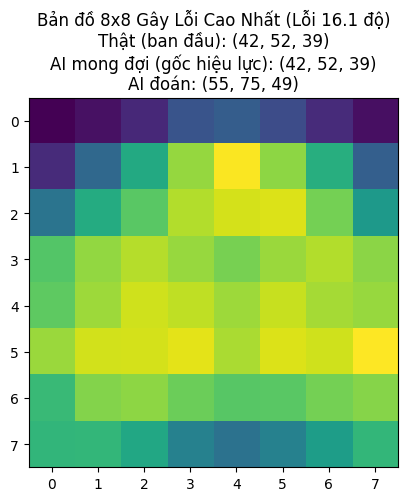

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

print("Đang tải thư viện và mô hình đã huấn luyện...")

# Tải mô hình AI đã huấn luyện (sigmoid output)
try:
    # Đảm bảo đây là tên file model đã train với sigmoid
    model = tf.keras.models.load_model('v5_model_doan_goc.keras') 
    print("Tải 'v3_model_doan_goc.keras' thành công.")
except IOError:
    print("LỖI: Không tìm thấy file model.")
    exit()

# =============================================================================
# PHẦN 1: TÁI TẠO BỘ DỮ LIỆU
# =============================================================================

K_THUOC = 8
SO_LUONG_MAU = 50000

# Đảm bảo hàm gia_lap_ban_do_tinh_v7 của bạn đã được sửa đổi để trả về 4 giá trị:
# ban_do, goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc_thuc
# Các hàm tao_dom_gaussian (wrap-around) cũng phải được định nghĩa TRƯỚC cell này.

print("Đang tạo lại bộ dữ liệu (20.000 mẫu). Xin chờ...")
start_time = time.time()

X_tinh = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1)) 
Y_tinh_raw = np.zeros((SO_LUONG_MAU, 3))         # Sẽ lưu các góc THẬT ban đầu (goc_DIP_ngau_nhien)
Y_tinh_to_predict = np.zeros((SO_LUONG_MAU, 3))  # Sẽ lưu các góc AI ĐƯỢC DẠY ĐOÁN (goc_DIP_hieu_luc_thuc)

for i in range(SO_LUONG_MAU):
    goc_MCP_ngau_nhien = np.random.uniform(0, 90)
    goc_PIP_ngau_nhien = np.random.uniform(0, 90)
    goc_DIP_ngau_nhien = np.random.uniform(0, 90) # Đây là góc DIP "thật" ban đầu

    # === SỬA ĐỔI: Hứng tất cả các giá trị trả về từ hàm gia_lap_ban_do_tinh_v7 ===
    ban_do_tinh_array, goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc_thuc = \
        gia_lap_ban_do_tinh_v7(goc_MCP_ngau_nhien, goc_PIP_ngau_nhien, goc_DIP_ngau_nhien, k_thuoc=K_THUOC)
    # --------------------------------------------------------------------------

    X_tinh[i] = ban_do_tinh_array.reshape(K_THUOC, K_THUOC, 1)
    
    # Lưu góc thật ban đầu (để so sánh ở phần phân tích lỗi)
    Y_tinh_raw[i] = [goc_MCP_ngau_nhien, goc_PIP_ngau_nhien, goc_DIP_ngau_nhien]
    
    # Lưu các góc mà AI THỰC SỰ ĐƯỢC HUẤN LUYỆN để đoán (MCP, PIP, DIP_hiệu_lực)
    Y_tinh_to_predict[i] = [goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc_thuc]

print(f"Đã tạo lại dữ liệu trong {time.time() - start_time:.2f} giây.")

# =============================================================================
# PHẦN 2: TÁCH DỮ LIỆU VÀ PHÂN TÍCH LỖI (ĐÃ CẬP NHẬT LOGIC SO SÁNH)
# =============================================================================

validation_split_ratio = 0.2
split_index = int(SO_LUONG_MAU * (1 - validation_split_ratio))

X_val = X_tinh[split_index:] 

# === THAY ĐỔI LỚN Ở ĐÂY: Dùng Y_tinh_to_predict làm "đáp án đúng" cho MAE ===
# Y_val_true_for_MAE là cái mà AI được kỳ vọng đoán ra (MCP, PIP, DIP_hiệu_lực)
Y_val_true_for_MAE = Y_tinh_to_predict[split_index:] 

# Y_val_true_original vẫn là góc thật ban đầu (MCP, PIP, DIP_chủ_động)
# Để chúng ta vẫn có thể hiển thị nó trong kết quả phân tích
Y_val_true_original = Y_tinh_raw[split_index:] 
# ==============================================================

print(f"Đã tách ra {len(X_val)} mẫu kiểm tra.")

print("Đang chạy dự đoán trên toàn bộ mẫu kiểm tra...")
Y_pred_norm = model.predict(X_val) # Y_pred_norm sẽ có giá trị từ 0-1 (do sigmoid)

# Tỷ lệ lại kết quả dự đoán về 0-90 độ
Y_pred = Y_pred_norm * 90.0

# Tính toán lỗi (So sánh dự đoán 0-90 với đáp án MÀ AI ĐƯỢC DẠY ĐOÁN)
errors = np.abs(Y_pred - Y_val_true_for_MAE) # Dùng Y_val_true_for_MAE
avg_errors_per_sample = np.mean(errors, axis=1)

sorted_indices = np.argsort(avg_errors_per_sample)[::-1] 

# =============================================================================
# PHẦN 3: IN KẾT QUẢ PHÂN TÍCH (ĐÃ CẬP NHẬT LOGIC HIỂN THỊ)
# =============================================================================
print("\n--- PHÂN TÍCH 20 TRƯỜNG HỢP LỖI CAO NHẤT ---")
actual_val_mae = np.mean(avg_errors_per_sample) # Tính lại MAE thực tế
print(f"(Tổng lỗi trung bình (val_mae) tính toán lại: {actual_val_mae:.2f} độ)")

for i in range(min(20, len(sorted_indices))): 
    idx = sorted_indices[i]
    
    # Góc THẬT ban đầu (để người đọc dễ hiểu)
    true_angles_original = Y_val_true_original[idx] 
    
    # Góc mà AI ĐƯỢC DẠY ĐOÁN (MCP, PIP, DIP_hiệu_lực) - để tính lỗi
    true_angles_for_mae = Y_val_true_for_MAE[idx] 
    
    pred_angles = Y_pred[idx]# Dự đoán đã tỷ lệ (0-90)
    sample_error = avg_errors_per_sample[idx]
    
    print(f"\n#{i+1}. Lỗi cao thứ {i+1} (Sai trung bình: {sample_error:.1f} độ)")
    print(f" > Sự thật (ban đầu): MCP={true_angles_original[0]:.1f}, PIP={true_angles_original[1]:.1f}, DIP={true_angles_original[2]:.1f}")
    print(f" > AI mong đợi (gốc hiệu lực): MCP={true_angles_for_mae[0]:.1f}, PIP={true_angles_for_mae[1]:.1f}, DIP={true_angles_for_mae[2]:.1f}")
    print(f" > AI đoán: MCP={pred_angles[0]:.1f}, PIP={pred_angles[1]:.1f}, DIP={pred_angles[2]:.1f}")

if len(sorted_indices) > 0:
    print("\n--- TRỰC QUAN HÓA TRƯỜNG HỢP TỆ NHẤT (Lỗi #1) ---")
    idx_worst = sorted_indices[0]
    true_angles_original_worst = Y_val_true_original[idx_worst] 
    true_angles_for_mae_worst = Y_val_true_for_MAE[idx_worst] 
    pred_angles_worst = Y_pred[idx_worst]
    anh_te_nhat = X_val[idx_worst].reshape(K_THUOC, K_THUOC)
    plt.imshow(anh_te_nhat, cmap='viridis')
    plt.title(f"Bản đồ 8x8 Gây Lỗi Cao Nhất (Lỗi {avg_errors_per_sample[idx_worst]:.1f} độ)\n"
              f"Thật (ban đầu): ({true_angles_original_worst[0]:.0f}, {true_angles_original_worst[1]:.0f}, {true_angles_original_worst[2]:.0f})\n"
              f"AI mong đợi (gốc hiệu lực): ({true_angles_for_mae_worst[0]:.0f}, {true_angles_for_mae_worst[1]:.0f}, {true_angles_for_mae_worst[2]:.0f})\n"
              f"AI đoán: ({pred_angles_worst[0]:.0f}, {pred_angles_worst[1]:.0f}, {pred_angles_worst[2]:.0f})") 
    plt.show()
else:
    print("Không có dữ liệu kiểm tra để trực quan hóa.")

In [ ]:
# =============================================================================
# PHẦN 5: KIỂM TRA (TEST) MÔ HÌNH VỚI MỘT DỮ LIỆU CỐ ĐỊNH (NHIỀU LẦN)
# =============================================================================

print("\n--- Bắt đầu Kiểm tra AI (tải model TỐT NHẤT) ---")

try:
    best_model_1 = tf.keras.models.load_model('model_doan_goc.keras')
    best_model_2 = tf.keras.models.load_model('model_doan_do_cung.keras')
    print("Tải model thành công.")
except IOError:
    print("Lỗi: Không tìm thấy file model đã lưu.")
    exit()

# --- Số lần test cho CÙNG MỘT DỮ LIỆU ---
SO_LAN_TEST = 5

# --- ĐỊNH NGHĨA 1 DỮ LIỆU TEST CỐ ĐỊNH (Bên ngoài vòng lặp) ---
print(f"\n--- KIỂM TRA CÙNG 1 DỮ LIỆU {SO_LAN_TEST} LẦN (để kiểm tra ảnh hưởng của nhiễu mô phỏng) ---")

# Bạn có thể thay đổi các giá trị thật này để test
goc_MCP_that = 45.0
goc_PIP_that = 60.0
goc_DIP_that = 20.0
do_cung_that = 7.5
L1_test = 2.0 # Giữ cố định L
L2_test = 2.0
L3_test = 1.0

# Vị trí thăm dò cố định
VI_TRI_THAM_DO_MAC_DINH = (5, 0) # Thăm dò khớp PIP, Mu bàn tay

print(f"   DỮ LIỆU GỐC (Sự thật): MCP={goc_MCP_that:.1f}, PIP={goc_PIP_that:.1f}, DIP={goc_DIP_that:.1f} | Độ cứng = {do_cung_that:.1f}")

# Biến để lưu tổng lỗi
total_error_mcp = 0
total_error_pip = 0
total_error_dip = 0
total_error_stiff = 0

for i in range(SO_LAN_TEST):
    print(f"\n>> Lần test #{i+1}:")

    # 1. TẠO "ẢNH" MỚI (vẫn từ góc thật, nhưng CÓ NHIỄU MỚI)
    #    Hàm gia_lap_ban_do_tinh có np.random... bên trong
    #    nên mỗi lần gọi sẽ ra một "ảnh" 8x8 hơi khác nhau.
    anh_tinh_test = gia_lap_ban_do_tinh_v7(goc_MCP_that, goc_PIP_that, goc_DIP_that, k_thuoc=K_THUOC)
    
    # Tạo ảnh động (cũng có nhiễu ngẫu nhiên)
    anh_dong_test = gia_lap_ban_do_dong(VI_TRI_THAM_DO_MAC_DINH, do_cung_that)

    anh_tinh_test_input = anh_tinh_test.reshape(1, K_THUOC, K_THUOC, 1)
    anh_dong_test_input = anh_dong_test.reshape(1, K_THUOC, K_THUOC, 1)

    # 2. Yêu cầu AI dự đoán (tắt verbose để đỡ rối)
    goc_du_doan_raw = best_model_1.predict(anh_tinh_test_input, verbose=0) 
    goc_du_doan = goc_du_doan_raw * 90.0
    do_cung_du_doan = best_model_2.predict(anh_dong_test_input, verbose=0)

    # 3. In kết quả so sánh
    pred_mcp = goc_du_doan[0][0]
    pred_pip = goc_du_doan[0][1]
    pred_dip = goc_du_doan[0][2]
    pred_stiff = do_cung_du_doan[0][0]
    print(f"   AI đoán:  MCP={pred_mcp:.1f}, PIP={pred_pip:.1f}, DIP={pred_dip:.1f} | Độ cứng = {pred_stiff:.1f}")

    # 4. Tính và in lỗi CHI TIẾT
    error_mcp = abs(pred_mcp - goc_MCP_that)
    error_pip = abs(pred_pip - goc_PIP_that)
    error_dip = abs(pred_dip - goc_DIP_that)
    error_stiff = abs(pred_stiff - do_cung_that)
    print(f"   => Lỗi: MCP: {error_mcp:.1f}°, PIP: {error_pip:.1f}°, DIP: {error_dip:.1f}° | Độ cứng: {error_stiff:.1f}")

    # Cộng dồn lỗi
    total_error_mcp += error_mcp
    total_error_pip += error_pip
    total_error_dip += error_dip
    total_error_stiff += error_stiff

# In lỗi trung bình (MAE) và Độ lệch chuẩn (Stability)
avg_mae_mcp = total_error_mcp / SO_LAN_TEST
avg_mae_pip = total_error_pip / SO_LAN_TEST
avg_mae_dip = total_error_dip / SO_LAN_TEST
avg_mae_stiff = total_error_stiff / SO_LAN_TEST

print("\n--- ĐỘ LỆCH TRUNG BÌNH (MAE) CHO CÙNG 1 TƯ THẾ ---")
print(f"   (Dựa trên {SO_LAN_TEST} lần chạy với nhiễu ngẫu nhiên)")
print(f"   MAE MCP: {avg_mae_mcp:.2f} độ")
print(f"   MAE PIP: {avg_mae_pip:.2f} độ")
print(f"   MAE DIP: {avg_mae_dip:.2f} độ")
print(f"   MAE Độ cứng: {avg_mae_stiff:.2f}")

print("\nHoàn tất kiểm tra.")


--- Bắt đầu Kiểm tra AI (tải model TỐT NHẤT) ---


NameError: name 'tf' is not defined